In [35]:
import torch
import gc
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import spacy
from SPARQLWrapper import SPARQLWrapper, JSON
from langchain.schema import Document
from langchain.vectorstores import Chroma
import time
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple

nlp = spacy.load("en_core_web_lg")

def extract_named_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        # Remove leading prepositions and articles
        words = ent.text.split()
        while words and words[0].lower() in ['the', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by']:
            words.pop(0)
        if words:  # Only add if there are words left after removing prepositions
            entities.append(' '.join(words))
    return entities

# DBpedia query setup
def generate_sparql_query(entity):
    return """
        PREFIX dbo: <http://dbpedia.org/ontology/>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX bif: <bif:>
        
        SELECT DISTINCT ?abstract
        WHERE {
            ?entity rdfs:label ?label ;
                    dbo:abstract ?abstract ;
                    a ?type .
            FILTER(LANG(?abstract) = 'en')
            FILTER(LANG(?label) = 'en')
            FILTER(bif:contains(?label, '"%s"'))
        }
        LIMIT 3
    """ % entity

def query_dbpedia(entity):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setQuery(generate_sparql_query(entity))
    sparql.setReturnFormat(JSON)

    try:
        results = sparql.query().convert()
        results = results['results']['bindings']
        if results:
            return [result['abstract']['value'] for result in results]
        return []
    except Exception as e:
        print(f"Error querying DBpedia: {e}")
        return []

# Document retrieval
def retrieve_docs(query, vectorstore, embedding_function=None):
    """Retrieve documents from vector store with DBpedia fallback"""
    try:
        # First try to get documents from the vector store
        docs = vectorstore.similarity_search(query, k=3)
        if docs:
            return {'source': 'vectorstore', 'documents': docs}
    except Exception as e:
        print(f"Error retrieving from vector store: {e}")
        # If vectorstore search fails, just continue to DBpedia
    
    # Extract entities for DBpedia query
    entities = extract_named_entities(query)
    if not entities:
        entities = [query]  # Use the query itself if no entities found
    
    all_docs = []
    for entity in entities:
        dbpedia_results = query_dbpedia(entity)
        if dbpedia_results:
            new_docs = [Document(page_content=content) for content in dbpedia_results]
            all_docs.extend(new_docs)
    
    if all_docs:
        # Add new documents to vector store for future retrieval
        if embedding_function:
            vectorstore.add_documents(all_docs)
        return {'source': 'dbpedia', 'documents': all_docs}
    else:
        return {'source': 'no_results', 'documents': []}


# Model management

In [36]:
def load_model_by_version(model_path, quantization="8bit"):
    """Load a specific model version with configurable quantization"""
    # Clear GPU memory before loading
    gc.collect()
    torch.cuda.empty_cache()
    
    # Configure quantization based on preference
    if quantization == "8bit":
        bnb_config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_enable_fp32_cpu_offload=True
        )
    elif quantization == "4bit":
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            llm_int8_enable_fp32_cpu_offload=True
        )
    else:
        raise ValueError(f"Unsupported quantization: {quantization}")
    
    # Get current CUDA device
    cuda_device = torch.cuda.current_device()
    device_map = {"": cuda_device}
    
    # Load base model
    print(f"Loading base model with {quantization} quantization...")
    base_model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-2-2b-it",
        quantization_config=bnb_config,
        device_map=device_map,
        offload_folder="offload",
        attn_implementation="eager"
    )
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
    tokenizer.pad_token = tokenizer.eos_token
    
    # Load LoRA adapter
    print(f"Loading adapter from: {model_path}")
    try:
        model = PeftModel.from_pretrained(
            base_model, 
            model_path,
            is_trainable=False
        )
        print("LoRA adapter loaded successfully!")
        model.eval()
        return model, tokenizer
    except Exception as e:
        print(f"Error loading adapter: {e}")
        import traceback
        traceback.print_exc()
        return None, None


# Text generation

In [37]:
def generate_text(model, tokenizer, prompt, max_length=300):
    """Generate text using the model with proper error handling"""
    if model is None or tokenizer is None:
        return "Model loading failed"
    
    # Tokenize the input
    try:
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        
        # Convert inputs to the right types
        inputs = {
            "input_ids": inputs["input_ids"].long(),
            "attention_mask": inputs["attention_mask"].long()
        }
        
        print(f"Input shape: {inputs['input_ids'].shape}")
        
        # Generate with proper error handling
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                min_new_tokens=100,
                do_sample=True,
                temperature=0.7,
                top_p=0.95,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode the entire output
        full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract just the generated part
        input_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
        
        if full_output.startswith(input_text):
            generated_text = full_output[len(input_text):].strip()
        else:
            # If exact matching doesn't work, look for the Answer: marker
            parts = full_output.split("Answer:")
            if len(parts) > 1:
                generated_text = "Answer:" + parts[1].strip()
            else:
                generated_text = full_output
        
        return generated_text
    except Exception as e:
        print(f"Generation error: {str(e)}")
        import traceback
        traceback.print_exc()
        return f"Error generating text: {str(e)}"


# Evaluation metrics

In [38]:
def evaluate_perplexity(model, tokenizer, eval_dataset):
    """Evaluate model perplexity on a dataset"""
    if model is None or tokenizer is None:
        return {"perplexity": float('inf'), "loss": float('inf')}
    
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    try:
        with torch.no_grad():
            for item in eval_dataset:
                # Format evaluation samples
                prompt = item["prompt"]
                response = item["response"]
                
                # Combine for full sequence evaluation
                full_text = prompt + response
                encodings = tokenizer(full_text, return_tensors="pt").to(model.device)
                
                # Shift tokens for causal LM evaluation
                input_ids = encodings.input_ids
                target_ids = input_ids.clone()
                
                # Calculate loss
                outputs = model(input_ids=input_ids, labels=target_ids)
                loss = outputs.loss.item()
                
                # Accumulate loss
                total_loss += loss * input_ids.size(1)
                total_tokens += input_ids.size(1)
        
        # Calculate perplexity
        avg_loss = total_loss / total_tokens
        perplexity = torch.exp(torch.tensor(avg_loss)).item()
        
        return {"perplexity": perplexity, "loss": avg_loss}
    except Exception as e:
        print(f"Evaluation error: {str(e)}")
        import traceback
        traceback.print_exc()
        return {"perplexity": float('inf'), "loss": float('inf')}


# Multi-model comparison

In [40]:
def compare_models(query, model_configs, vectorstore, max_tokens=300):
    """
    Compare multiple model configurations on the same query
    
    Args:
        query: The user query string
        model_configs: List of dicts with 'path' and 'quantization' keys
        vectorstore: Vector store for document retrieval
        max_tokens: Maximum tokens to generate
        
    Returns:
        Dict of results by model
    """
    results = {}
    
    #ensure fair comparison
    retrieval_result = retrieve_docs(query, vectorstore)
    retrieved_info = "\n".join([doc.page_content for doc in retrieval_result['documents']])
    
    # Build the prompt
    
    if retrieved_info:
        prompt = f"""Use the following information to answer the question:

{retrieved_info}

Question: {query}

Important instructions:
1. Answer ONLY based on the information provided above
2. If the information doesn't fully answer the question, use what IS available to provide a partial answer
3. Do NOT suggest how to research the topic further
4. Do NOT apologize for incomplete information
5. If you truly cannot answer any part of the question from the provided information, simply state "The provided information doesn't contain details about [specific aspect]."

Answer:"""
    else:
        prompt = f"""Question: {query}

Important instructions:
1. Provide a factual historical answer based on your training
2. Do NOT suggest research methods or apologize for your answer
3. Present information confidently and directly

Answer:"""
    
    
    # Try each model configuration
    for config in model_configs:
        model_path = config['path']
        quant = config.get('quantization', '8bit')
        
        print(f"\nTesting model: {model_path} with {quant} quantization")
        
        # Record metrics
        start_time = time.time()
        
        # Load the model
        model, tokenizer = load_model_by_version(model_path, quant)
        
        if model is None:
            results[model_path] = {
                "error": "Failed to load model",
                "time": 0,
                "source": retrieval_result['source']
            }
            continue
            
        # Generate answer
        answer = generate_text(model, tokenizer, prompt, max_tokens)
        
        # Calculate time taken
        gen_time = time.time() - start_time
        
        # Store result
        results[model_path] = {
            "answer": answer,
            "time": gen_time,
            "source": retrieval_result['source'],
            "quantization": quant
        }
        
        # tensorflow tends to eat up gpu memory, i need to clear it
        del model, tokenizer
        gc.collect()
        torch.cuda.empty_cache()
    
    return results


# Main RAG pipeline with model evaluation

In [41]:
def create_comparison_table(results, output_file="model_comparison_table.png"):
    """Create a visual table of the comparison results"""
    # Prepare data for the table
    data = []
    for model, result in results.items():
        data.append({
            "Model": model.split('/')[-1],
            "Quantization": result["quantization"],
            "Time (s)": f"{result['time']:.2f}",
            "Answer Length": len(result["answer"])
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Create the table visualization
    plt.figure(figsize=(10, len(data) * 0.5 + 1))
    
    # Hide axes
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(False)
    
    # Create table
    table = plt.table(
        cellText=df.values,
        colLabels=df.columns,
        loc='center',
        cellLoc='center',
        colColours=['#f2f2f2'] * len(df.columns)
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    # Save
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Comparison table saved to {output_file}")
    return output_file

In [42]:
import csv
import os
from datetime import datetime


def save_to_csv(results, query, filename="model_comparison.csv"):
    """Save results to CSV file"""
    # Check if file exists
    file_exists = os.path.isfile(filename)
    
    # Create rows for CSV
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    rows = []
    
    for model_path, result in results.items():
        model_name = model_path.split('/')[-1]
        row = {
            "timestamp": timestamp,
            "query": query,
            "model_name": model_name,
            "quantization": result["quantization"],
            "generation_time": result["time"],
            "answer_length": len(result["answer"]),
            "answer": result["answer"]
        }
        rows.append(row)
    
    # Get all field names
    fieldnames = list(rows[0].keys())
    
    # Write to CSV
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerows(rows)
    
    print(f"Results saved to {filename}")

In [43]:
def save_responses(results, query):
    """Save full responses to individual text files"""
    # Create folder for responses
    folder = "model_responses"
    os.makedirs(folder, exist_ok=True)
    
    # Create a timestamp and clean query for filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    query_filename = "".join(c if c.isalnum() else "_" for c in query)[:30]
    
    # Save each response
    files = []
    for model_path, result in results.items():
        model_name = model_path.split('/')[-1]
        filename = f"{folder}/{timestamp}_{model_name}_{query_filename}.txt"
        
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(f"Query: {query}\n")
            file.write(f"Model: {model_path}\n")
            file.write(f"Quantization: {result['quantization']}\n")
            file.write(f"Generation Time: {result['time']:.2f} seconds\n")
            file.write("\n" + "="*50 + "\n\n")
            file.write(result["answer"])
        
        files.append(filename)
        print(f"Response saved to {filename}")
    
    return files


In [44]:
from langchain.embeddings.base import Embeddings
def run_rag_pipeline():
    """Run the complete RAG pipeline with model comparison"""
    class LocalServerEmbeddings(Embeddings):
        def __init__(self, base_url: str):
            self.base_url = base_url
            self.model = "text-embedding-nomic-embed-text-v1.5"

        def embed_documents(self, texts: List[str]) -> List[List[float]]:
            import requests
            response = requests.post(f"{self.base_url}/embeddings", json={"input": texts})
            data = response.json()
            return [item["embedding"] for item in data["data"]]

        def embed_query(self, text: str) -> List[float]:
            import requests
            response = requests.post(f"{self.base_url}/embeddings", json={"input": [text]})
            data = response.json()
            return data["data"][0]["embedding"]
    
    # Setup vector store
    try:
        print("Setting up embedding model and vector store...")
        embedding = LocalServerEmbeddings(base_url="http://localhost:4500/v1")
        vectorstore = Chroma(persist_directory="chroma/", embedding_function=embedding)
        print("Vector store initialized successfully!")
    except Exception as e:
        print(f"Error setting up vector store: {e}")
        print("Will fallback to DBpedia only")
        vectorstore = None
    
    # Define model configs to test
    model_configs = [
        {"path": "./models_r8_8_final", "quantization": "8bit"},
        {"path": "./models_r16_4_final", "quantization": "4bit"},
        {"path":"./models_r4_4_final", "quantization": "4bit"},
        {"path": "./models_r8_4_final", "quantization": "4bit"},
        {"path":"./models_r16_8_final", "quantization": "8bit"},
    ]
    
    # Get user query
    query = "What were the key political, social, and economic developments in France during 18th Century?"
    
    # Run comparison
    results = compare_models(query, model_configs, vectorstore)
    
    # Display results
    print("\n" + "="*80)
    print(f"Results for query: '{query}'")
    print("="*80)
    
    for model_path, result in results.items():
        print(f"\nModel: {model_path} ({result.get('quantization', 'unknown')})")
        print(f"Time taken: {result['time']:.2f} seconds")
        print(f"Information source: {result['source']}")
        
        if "error" in result:
            print(f"Error: {result['error']}")
        else:
            print("\nResponse:")
            print("-"*50)
            print(result["answer"])
            print("-"*50)
    
    # Create comparison visualization
    model_names = [f"{path.split('/')[-1]} ({cfg['quantization']})" 
                  for path, cfg in zip([c['path'] for c in model_configs], model_configs)]
    times = [results[c['path']]['time'] for c in model_configs if c['path'] in results]
    
    if len(times) > 1: 
        plt.figure(figsize=(10, 6))
        plt.bar(model_names, times)
        plt.title('Generation Time Comparison')
        plt.xlabel('Model')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('model_comparison.png')
        print("\nComparison chart saved as 'model_comparison.png'")
    
    # Save results to CSV
    save_to_csv(results, query)
    # Save full responses to text files
    save_responses(results, query)
    # Create a visual table of the comparison results
    create_comparison_table(results)

Setting up embedding model and vector store...
Vector store initialized successfully!
Error retrieving from vector store: 'data'

Testing model: ./models_r8_8_final with 8bit quantization
Loading base model with 8bit quantization...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


Loading adapter from: ./models_r8_8_final
LoRA adapter loaded successfully!
Input shape: torch.Size([1, 487])

Testing model: ./models_r16_4_final with 4bit quantization
Loading base model with 4bit quantization...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


Loading adapter from: ./models_r16_4_final
LoRA adapter loaded successfully!
Input shape: torch.Size([1, 487])

Testing model: ./models_r4_4_final with 4bit quantization
Loading base model with 4bit quantization...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Loading adapter from: ./models_r4_4_final
LoRA adapter loaded successfully!
Input shape: torch.Size([1, 487])

Testing model: ./models_r8_4_final with 4bit quantization
Loading base model with 4bit quantization...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Loading adapter from: ./models_r8_4_final
LoRA adapter loaded successfully!
Input shape: torch.Size([1, 487])

Testing model: ./models_r16_8_final with 8bit quantization
Loading base model with 8bit quantization...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Loading adapter from: ./models_r16_8_final
LoRA adapter loaded successfully!
Input shape: torch.Size([1, 487])

Results for query: 'What were the key political, social, and economic developments in France during 18th Century?'

Model: ./models_r8_8_final (8bit)
Time taken: 58.58 seconds
Information source: dbpedia

Response:
--------------------------------------------------
Here's what we know about France's development during the 18th century: 

* **Political:**  France experienced major shifts. It saw the end of the reign of King Louis XIV, marking the beginning of new eras.  It played host to the birth of the Enlightenment, which had significant influence throughout the century and contributed heavily to French intellectual life. Finally, Paris served as a focal point for the tumultuous events of the French Revolution.   
* **Social:** Paris became an important hub for cultural activity. Notable architectural landmarks like the Champs-Élysées, Place Vendôme, and the Panthéon emerge

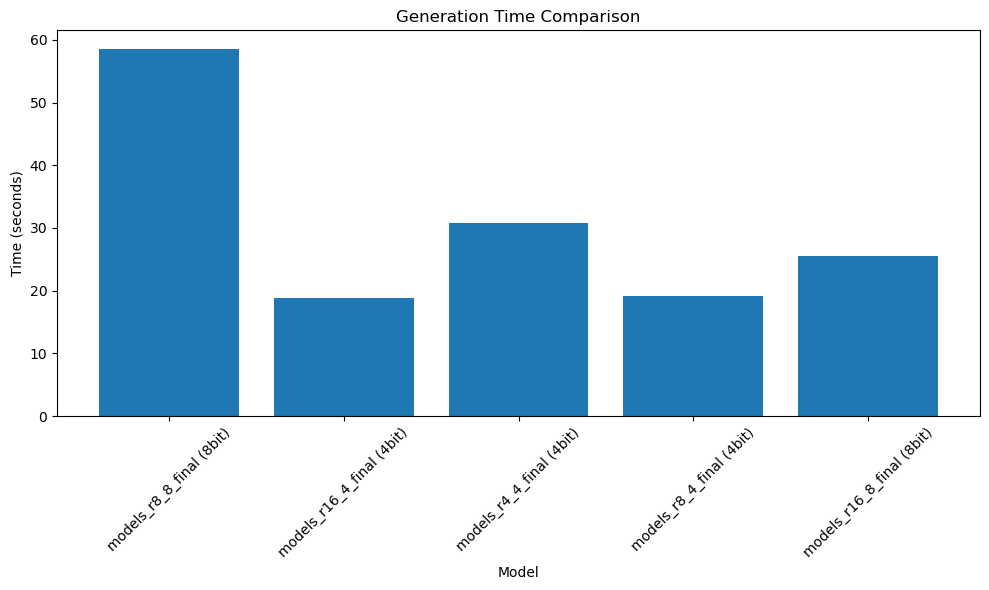

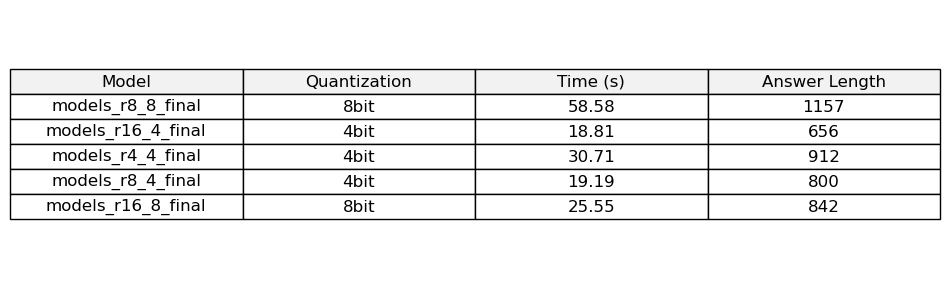

In [45]:
run_rag_pipeline()

In [ ]:
import pandas as pd

def escape_latex(text):
    if not isinstance(text, str):
        return text
    replacements = {
        '\\': r'\textbackslash{}',
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '’': "'",
        '–': '-', 
        '—': '-', 
        '…': '...',
        'é': 'e',
    }
    for orig, repl in replacements.items():
        text = text.replace(orig, repl)
    return text

# Load the CSV
df = pd.read_csv("model_comparison.csv") 

# Escape only string/text columns
for col in ['timestamp', 'query', 'model_name', 'quantization', 'answer_preview']:
    df[col] = df[col].apply(escape_latex)

# Generate LaTeX table
latex_code = r"""\documentclass{article}
\usepackage{longtable}
\usepackage{geometry}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{caption}
\renewcommand{\arraystretch}{1.2}
\geometry{margin=1in}
\begin{document}

\begin{center}
\Large \textbf{Model Generation Output Comparison}
\end{center}

\begin{longtable}{|p{2.8cm}|p{4.2cm}|p{2.8cm}|p{1cm}|p{1.5cm}|p{1.2cm}|p{5cm}|}
\hline
\textbf{Timestamp} & \textbf{Query} & \textbf{Model Name} & \textbf{Quant.} & \textbf{Gen. Time} & \textbf{Ans. Len.} & \textbf{Answer Preview} \\
\hline
\endfirsthead

\hline
\textbf{Timestamp} & \textbf{Query} & \textbf{Model Name} & \textbf{Quant.} & \textbf{Gen. Time} & \textbf{Ans. Len.} & \textbf{Answer Preview} \\
\hline
\endhead
"""

# Add rows
for _, row in df.iterrows():
    latex_code += f"{row['timestamp']} & {row['query']} & {row['model_name']} & {row['quantization']} & {row['generation_time']:.2f} & {row['answer_length']} & {row['answer_preview']} \\\\\n\\hline\n"

latex_code += r"""\end{longtable}
\end{document}
"""

# Save to file
with open("output_table.tex", "w", encoding="utf-8") as f:
    f.write(latex_code)

print( "LaTeX code saved to output_table.tex")
